# Heave Modeling

Understanding how to correlate heave with weather data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# namedtuple
from collections import namedtuple

In [2]:
def read_files_into_dataframes(path, filename, date_column_name):
    """
    This function read a csv file into, considering a specific column as date e set it as index.
    
    args:
    path (str) -> Base directory.
    filename (str) -> .csv file located into path.
    date_column_name (str) -> column name with time information.
    
    return:
    DataFrame -> return a dataframe with date_column_name as index and in datetime format.
    
    """
    
    if filename.split('.')[-1] != 'csv':
        
        raise ValueError('Enter a valid csv filename')
    
    df = pd.read_csv(''.join([path, filename]), parse_dates=[date_column_name], dtype='float32')
    df.set_index(date_column_name, inplace=True)
    return df

In [3]:
base_path = 'data\\'

# Reading Training Dataset

In [4]:
training_filename = 'complete_data_train.csv'
complete_data_train = read_files_into_dataframes(base_path, training_filename, date_column_name='Date')

In [5]:
complete_data_train.head()

Heave      Roll     Pitch        Hs       Hss  \
Date                                                                          
2020-08-15 00:00:00+00:00 -0.460648 -1.364725 -0.044143  2.600000  1.600000   
2020-08-15 00:00:01+00:00 -0.495906 -1.064388 -0.239000  2.600028  1.600028   
2020-08-15 00:00:02+00:00 -0.262876 -0.580920 -0.223428  2.600055  1.600056   
2020-08-15 00:00:03+00:00  0.049354 -0.185133 -0.104570  2.600083  1.600083   
2020-08-15 00:00:04+00:00  0.358442  0.258371  0.067386  2.600111  1.600111   

                           Hsw        Tp        Tps       Tpw       DIRM  \
Date                                                                       
2020-08-15 00:00:00+00:00  2.1  8.000000  11.200000  8.400000  66.000000   
2020-08-15 00:00:01+00:00  2.1  7.999972  11.199750  8.399917  65.999443   
2020-08-15 00:00:02+00:00  2.1  7.999944  11.199500  8.399833  65.998886   
2020-08-15 00:00:03+00:00  2.1  7.999917  11.199250  8.399750  65.998337   
2020-08-15 00:00:04+00:00  2.1  7.999889  11.198999  8.399666  65.997780   

                                DIRPs      DIRPw  
Date                                              
2020-08-15 00:00:00+00:00  143.000000  46.000000  
2020-08-15 00:00:01+00:00  142.996948  45.999168  
2020-08-15 00:00:02+00:00  142.993896  45.998333  
2020-08-15 00:00:03+00:00  142.990829  45.997501  
2020-08-15 00:00:04+00:00  142.987778  45.996666

# Reading Testing dataset

In [6]:
testing_filename = 'complete_data_test.csv'
complete_data_test = read_files_into_dataframes(base_path, testing_filename, date_column_name='Date')

In [7]:
complete_data_test.head()

Heave      Roll     Pitch   Hs  Hss       Hsw  \
Date                                                                          
2020-08-31 00:00:00+00:00 -0.329711 -0.777145 -0.189899  1.7  1.7  0.500000   
2020-08-31 00:00:01+00:00 -0.286512 -0.871760  0.216196  1.7  1.7  0.499972   
2020-08-31 00:00:02+00:00 -0.013655 -0.767476  0.559503  1.7  1.7  0.499944   
2020-08-31 00:00:03+00:00  0.332656 -0.572106  0.597722  1.7  1.7  0.499917   
2020-08-31 00:00:04+00:00  0.548310 -0.358734  0.225391  1.7  1.7  0.499889   

                            Tp  Tps       Tpw       DIRM  DIRPs      DIRPw  
Date                                                                        
2020-08-31 00:00:00+00:00  8.3  8.4  5.200000  67.000000   71.0  15.000000  
2020-08-31 00:00:01+00:00  8.3  8.4  5.199944  67.000275   71.0  15.000278  
2020-08-31 00:00:02+00:00  8.3  8.4  5.199889  67.000557   71.0  15.000556  
2020-08-31 00:00:03+00:00  8.3  8.4  5.199833  67.000832   71.0  15.000834  
2020-08-31 00:00:04+00:00  8.3  8.4  5.199778  67.001114   71.0  15.001111

# Correlation Analysis

This notebook will specifically build a model for heave. One way to analyze how an output correlates with inputs is to do a correlation analysis.

In [8]:
model_inputs = ['Hs', 'Hss', 'Hsw', 'Tp', 'Tps', 'Tpw', 'DIRM', 'DIRPs', 'DIRPw']
model_output = ['Heave']

In [9]:
heave_inputs = complete_data_train[model_output + model_inputs].copy()
corr_df = heave_inputs.corr(method='spearman')
heave_weather_corr = corr_df.Heave
heave_weather_corr = np.abs(heave_weather_corr)
heave_weather_corr.sort_values(ascending=False, inplace=True)
display(heave_weather_corr)

Heave    1.000000
Hss      0.000242
DIRM     0.000204
Hs       0.000198
DIRPs    0.000187
Tps      0.000181
Tpw      0.000132
Hsw      0.000115
Tp       0.000094
DIRPw    0.000055
Name: Heave, dtype: float64

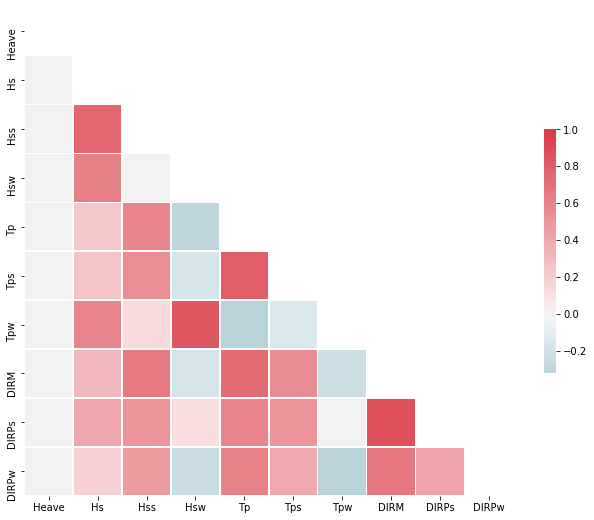

In [10]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Conclusions:__

For correlation analysis, the spearman correlation was used due to the transient characteristic of the data. The correlation with all inputs was close to zero.

# Scatter Plot Analysis

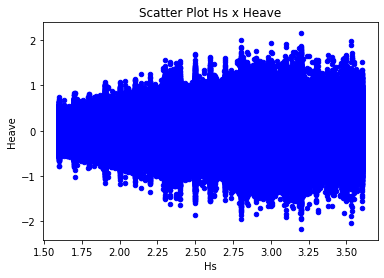

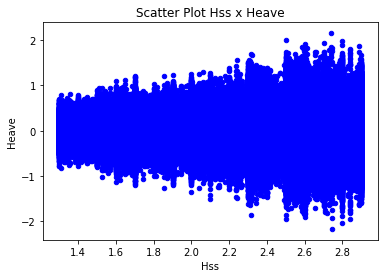

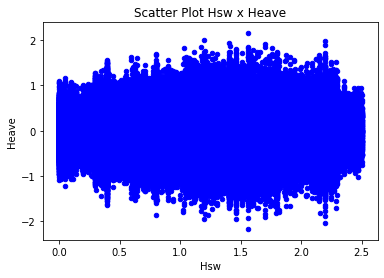

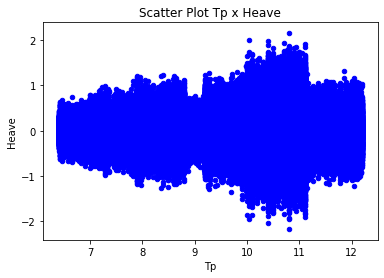

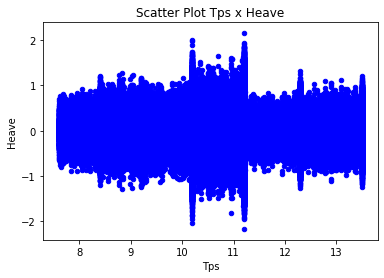

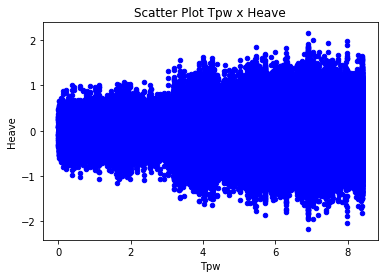

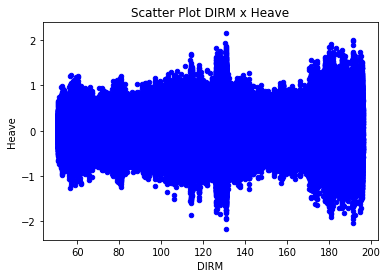

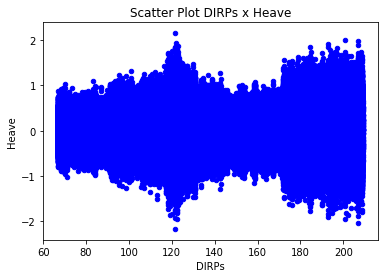

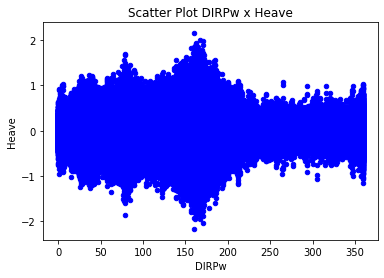

In [11]:
for column in model_inputs:

    heave_inputs.plot.scatter(x=column, y='Heave', title=f'Scatter Plot {column} x Heave', c='blue')
    plt.show()

__Conclusions:__



# Creating a baseline model

__1__ - Apply Standard Scale into data\
__2__ - Train model with standardized data\
__3__ - Apply the model in test data\
__4__ - Calculate metrics\
__5__ - Observe transient behavior

# Applying Transformation into original data.

__MinMaxScaler:__ Add or subtract a constant. Then multiply or divide by another constant. MinMaxScaler subtracts the minimum value in the column and then divides by the difference between the original maximum and original minimum.

__RobustScaler:__ Robust Scaler standardizes a feature by removing the median and dividing each feature by the interquartile range.

__StandardScaler:__ StandardScaler standardizes a feature by removing the mean and dividing each value by the standard deviation.

Considering these types of transformations, the MinMaxScaler will be used first.

__reference:__ [scale-standardize-or-normalize-with-scikit-learn](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

In [12]:
x = heave_inputs[model_inputs].copy()
y = heave_inputs.Heave.values
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(heave_inputs[model_inputs])

# Training Gradient Boosting Regressor Baseline

In [13]:
gbr = GradientBoostingRegressor()
gbr.fit(x_sc, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Mount pipeline

In [14]:
pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

# Applying baseline model in test data.

In [15]:
y_test_baseline = complete_data_test.Heave.values
y_pred_baseline = pipeline.predict(complete_data_test[model_inputs])

In [16]:
def calculate_accuracy(y_real, y_pred, error_range=0.1) -> float:
    """
    This function calculates accuracy considering a passed error_range and two vectors, one for real values and another one for
    predicted values.
    
    args:
    
    y_real (iterable) -> array with real values.
    y_pred (iterable) -> array with predicted values.
    error_range (float) -> percentual to be considered as error comparing predict and real values. Consider format with decimals
                           ex: 0.1 -> 10%
    returns:
    acc (float) -> accuracy considering the passed error range with percent format (0 - 100%) with 2 degrees of precision.
    
    """
    difference_y = y_pred - y_real
    modular_difference_y = np.sqrt(difference_y**2)
    
    error_range_values = y_real * error_range
    
    acc = 1 - (sum(modular_difference_y > error_range_values) / len(modular_difference_y))
    acc =   np.round(acc * 100, 2)
    
    return acc

def plot_model_accuracy(y_real,
                        y_predict,
                        start_num=0,
                        end_num=-1,
                        title='Titulo Modelo'):
    """
    This function plots the predicted result against real data to observe the dynamic behavior.
    
    args:
    
    y_real (iterable) -> Real data of the target variable.
    y_predict (iterable) -> Predicted data of target variable.
    start_num (int) -> Position to start plot based on real and predicted data.
    end_num (int) -> Position to end plot based on real and predicted data.
    title (str) -> Title to define 
    
    return:
    
    None
    """
    
    
    plt.figure(figsize=(15,5))
    plt.autoscale(enable=True)
    plt.grid(True)
    
    # Plot real lab data
    plt.plot(y_real[start_num:end_num],
             label='Real',
             linewidth=0.5,
             linestyle='--',
             marker='o',
             markersize=2,
             color = 'royalblue')
    
    # Plot predicted IF
    plt.plot(y_predict[start_num:end_num],
             label='Predicted',
             linewidth=1.0,
             color = 'orange')

    plt.title(title)
    plt.xlabel('Data Points')
    plt.ylabel(title.split()[0])
    plt.legend(loc=('upper right'))
    plt.show()
    
    return None

def print_column_names(column_names: list):
    """
    This function prints lists in a beautiful way.
    """
    
    print('Features used in this model:')
    print('')
    
    for i, name in enumerate(column_names):
        
        print(f'{i + 1} - {name}')
      
    print('')
    return None

In [17]:
acc_baseline = calculate_accuracy(y_test_baseline, y_pred_baseline)
print(f'acc(10%):>> {acc_baseline}')

acc(10%):>> 0.01


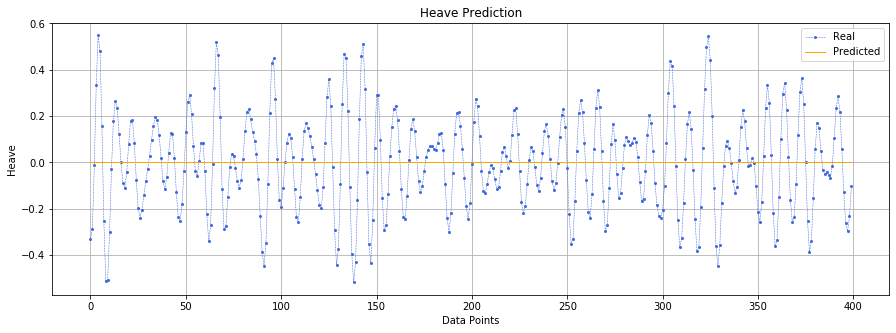

In [18]:
plot_model_accuracy(y_test_baseline, y_pred_baseline, start_num=0, end_num=400, title='Heave Prediction')

__Conclusions:__

The model has no variability, being unable to predict the oscillatory behavior of the output.

# Test by removing features with less correlation.

- Gradient Boosting Regressor
- Order features considering correlation with `Heave`.
- Loop removing one feature with less correlation for each iteration.

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs
5 - Tps
6 - Tpw
7 - Hsw
8 - Tp
9 - DIRPw

acc(10%):>> 0.0


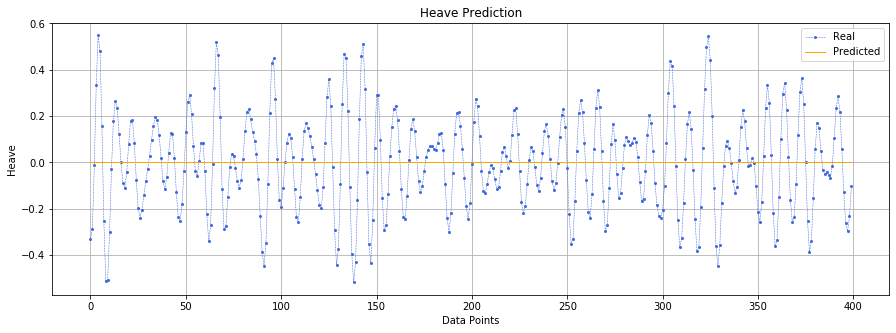

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs
5 - Tps
6 - Tpw
7 - Hsw
8 - Tp

acc(10%):>> 0.0


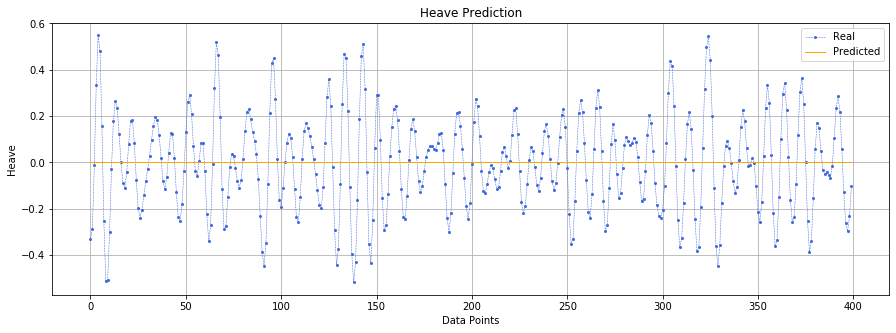

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs
5 - Tps
6 - Tpw
7 - Hsw

acc(10%):>> 0.0


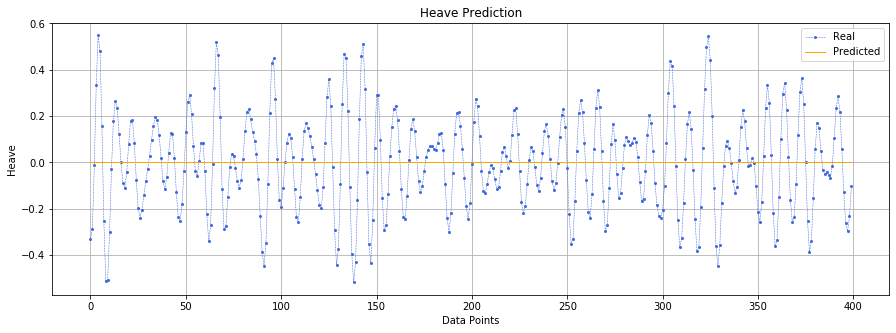

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs
5 - Tps
6 - Tpw

acc(10%):>> 0.0


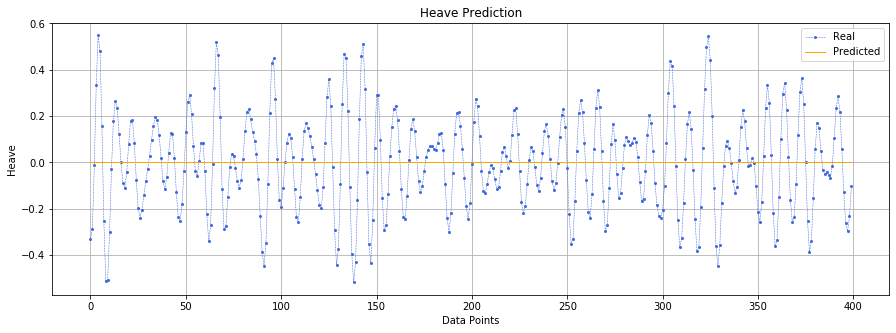

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs
5 - Tps

acc(10%):>> 0.0


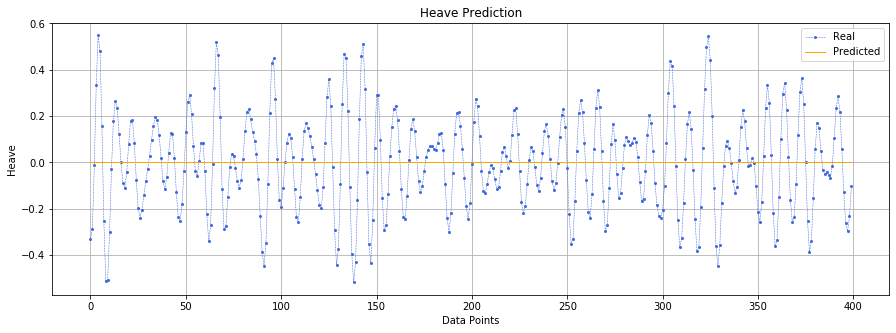

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs
4 - DIRPs

acc(10%):>> 0.0


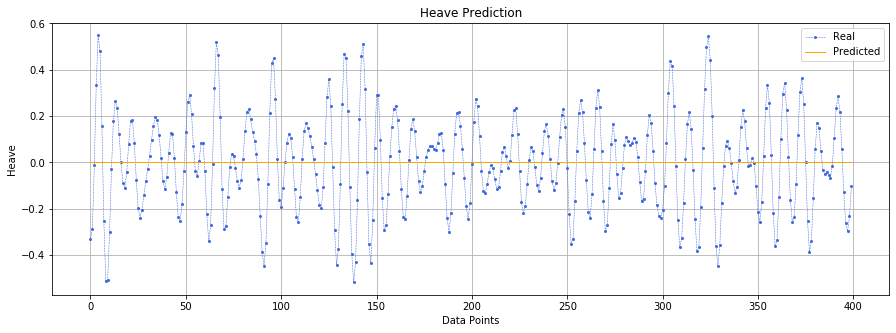

Features used in this model:

1 - Hss
2 - DIRM
3 - Hs

acc(10%):>> 0.0


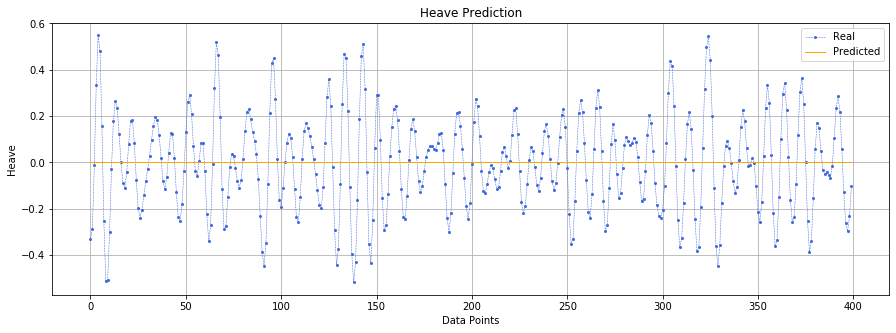

Features used in this model:

1 - Hss
2 - DIRM

acc(10%):>> 0.0


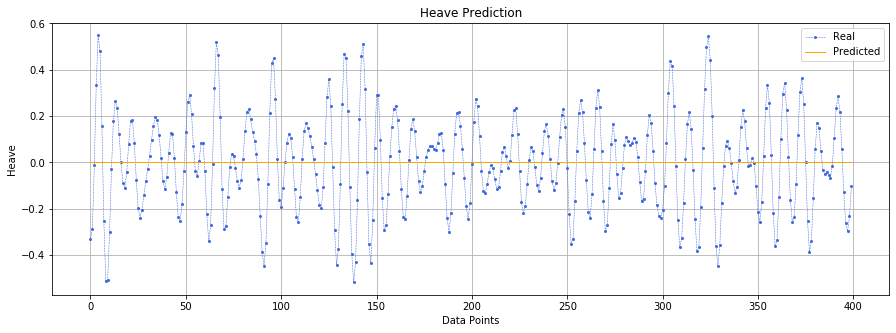

Features used in this model:

1 - Hss

acc(10%):>> 0.0


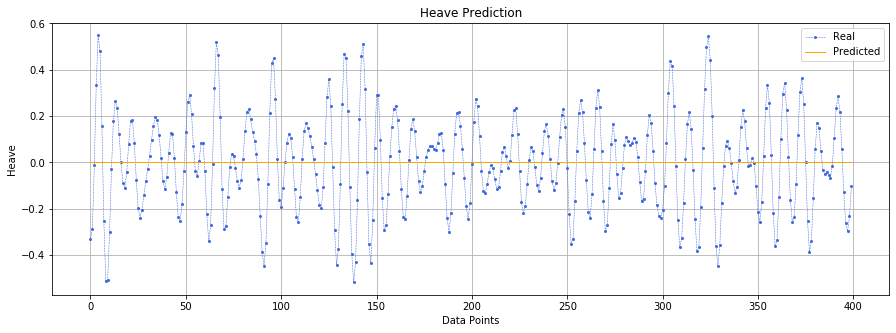

In [19]:
# Model Inputs ordered by correlation factor
model_inputs_ordered_by_corr = heave_weather_corr.index.tolist()
model_inputs_ordered_by_corr = [value for value in model_inputs_ordered_by_corr if value != 'Heave']

scaler = MinMaxScaler()
gbr = GradientBoostingRegressor()

for _ in range(len(model_inputs_ordered_by_corr)):
    
    print_column_names(model_inputs_ordered_by_corr)
    
    x = heave_inputs[model_inputs_ordered_by_corr].copy()
    y = heave_inputs.Heave.values
    x_sc = scaler.fit_transform(x)
    
    gbr.fit(x_sc, y)
    
    pipeline = Pipeline([('scaler', scaler), ('model', gbr)])
    
    y_test = complete_data_test.Heave.values
    y_pred = pipeline.predict(complete_data_test[model_inputs_ordered_by_corr])
    
    
    acc = calculate_accuracy(y_test, y_pred)
    print(f'acc(10%):>> {acc}')
    
    plot_model_accuracy(y_test, y_pred, start_num=0, end_num=400, title='Heave Prediction')
    
    model_inputs_ordered_by_corr.pop()

__Conclusions:__

Considering the training with interpolated data, it was seen that the model has no variability. With that, other strategies need to be tested. Probably the lack of variability of the model is due to a high number of weather data that result in the same range of heave, with that the oscillatory characteristic is lost. As next steps, a case will be tested considering only existing points without interpolation and another case considering the interpolated but balanced dataset.

# Analysing distribution of Heave data into train and test dataset.

- `complete_data_train` - Interpolated dataset used to train. 
- `complete_data_test` - Interpolated dataset used to test models.

Min x Max Values
Min value Heave[Train]: -2.176781415939331
Max value Heave[Train]: 2.1598310470581055

Min x Max Values
Min value Heave[Test]: -1.797236442565918
Max value Heave[Test]: 2.1028642654418945

Min x Max Values
Min value Heave[Predicted]: -0.38723168108621686
Max value Heave[Predicted]: 0.15650672935571025


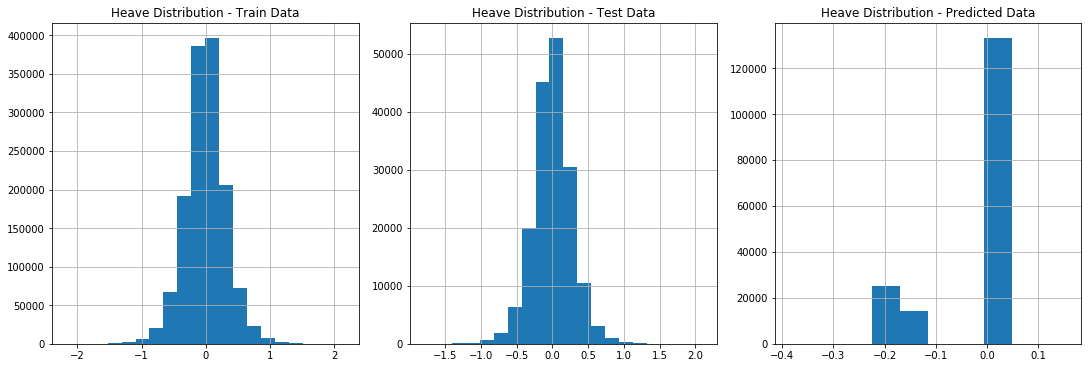

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5));

print("Min x Max Values")
print(f"Min value Heave[Train]: {complete_data_train.Heave.min()}")
print(f"Max value Heave[Train]: {complete_data_train.Heave.max()}")
print('')

complete_data_train.Heave.hist(bins=20, ax=axs[0]);
axs[0].set_title("Heave Distribution - Train Data");

print("Min x Max Values")
print(f"Min value Heave[Test]: {complete_data_test.Heave.min()}")
print(f"Max value Heave[Test]: {complete_data_test.Heave.max()}")
print('')
complete_data_test.Heave.hist(bins=20, ax=axs[1]);
axs[1].set_title("Heave Distribution - Test Data");

print("Min x Max Values")
print(f"Min value Heave[Predicted]: {y_pred_baseline.min()}")
print(f"Max value Heave[Predicted]: {y_pred_baseline.max()}")
plt.hist(y_pred_baseline)
plt.grid(True)
axs[2].set_title("Heave Distribution - Predicted Data");


plt.show()

__Conclusions:__

As expected, the histograms of the "Heave" data distribution point to a high occurrence of values around zero and few values that characterize the maximum and minimum amplitudes of the oscillations. With that, the idea of balancing the data becomes interesting, at least with an undersample of the region around zero.

To continue the analysis, two cases will be tested:

- __Case 1:__ Use the original weather data syncronized with vessel response without interpolation to train a model.
- __Case 2:__ Use balanced interpolated data considering undersampling for the region with the highest concentration of data.

# Case 1

`complete_data_train` - dataset interpolated, to get the original data, just resample by hour getting the first point.

In [21]:
complete_data_train_original_weather_data = complete_data_train.resample('H').first()

In [22]:
complete_data_train_original_weather_data.head()

Heave      Roll     Pitch   Hs  Hss  Hsw   Tp  \
Date                                                                          
2020-08-15 00:00:00+00:00 -0.460648 -1.364725 -0.044143  2.6  1.6  2.1  8.0   
2020-08-15 01:00:00+00:00 -0.058798 -0.929555 -0.038290  2.7  1.7  2.1  7.9   
2020-08-15 02:00:00+00:00  0.339358  0.248325  0.732794  2.7  1.7  2.2  7.9   
2020-08-15 03:00:00+00:00 -0.001892  0.606481  0.296092  2.8  1.7  2.2  7.9   
2020-08-15 04:00:00+00:00 -0.084712 -0.815989  0.153694  2.8  1.7  2.2  7.9   

                            Tps  Tpw  DIRM  DIRPs  DIRPw  
Date                                                      
2020-08-15 00:00:00+00:00  11.2  8.4  66.0  143.0   46.0  
2020-08-15 01:00:00+00:00  10.3  8.1  64.0  132.0   43.0  
2020-08-15 02:00:00+00:00   9.3  7.9  62.0  128.0   42.0  
2020-08-15 03:00:00+00:00   8.4  7.6  61.0  125.0   41.0  
2020-08-15 04:00:00+00:00   8.4  7.9  60.0  122.0   40.0

# Let's analyse correlation again considering `Heave` and `weather data`.

In [67]:
model_inputs = ['Hs', 'Hss', 'Hsw', 'Tp', 'Tps', 'Tpw', 'DIRM', 'DIRPs', 'DIRPw']
model_output = ['Heave']

In [24]:
corr_with_original_data = complete_data_train_original_weather_data[model_output + model_inputs].corr(method='spearman')

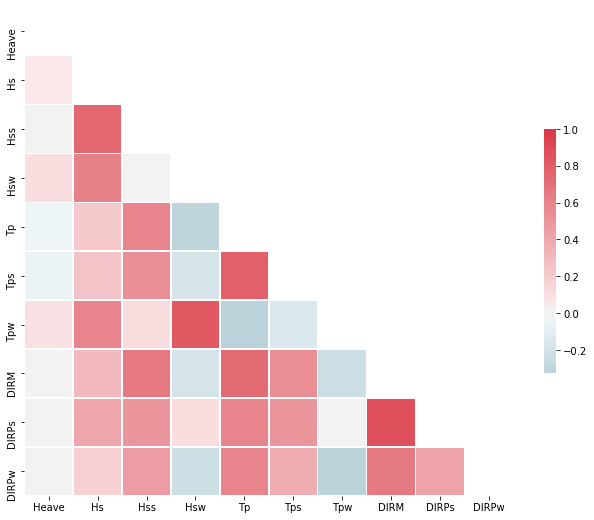

In [25]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_with_original_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr_with_original_data, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
display(np.abs(corr_with_original_data.Heave).sort_values(ascending=False))
model_input_corr_order = np.abs(corr_with_original_data.Heave).sort_values(ascending=False).index.tolist()
model_input_corr_order = [value for value in model_input_corr_order if value != 'Heave']

Heave    1.000000
Hsw      0.110735
Tpw      0.100781
Tps      0.058883
Hs       0.054794
Tp       0.038992
DIRPs    0.011044
DIRM     0.007687
Hss      0.003750
DIRPw    0.003363
Name: Heave, dtype: float64

In [27]:
# Define x and y to train the model.
x = complete_data_train_original_weather_data[model_inputs].copy()
y = complete_data_train_original_weather_data.Heave.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr = GradientBoostingRegressor()
gbr.fit(x_sc, y)

pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

acc(10%) >> 0.0
r2_score >> -0.23


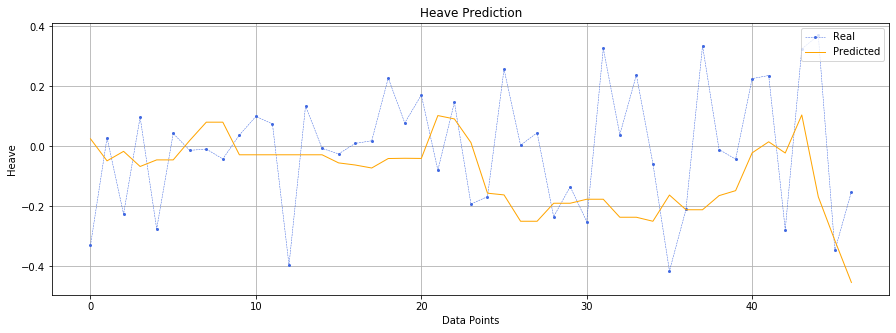

In [28]:
# Apply the same resample technique into test data
complete_data_test_weather_original_data = complete_data_test.resample('H').first()

y_test_original_weather = complete_data_test_weather_original_data.Heave.values
y_pred_original_weather = pipeline.predict(complete_data_test_weather_original_data[model_inputs])

acc = calculate_accuracy(y_test_original_weather, y_pred_original_weather, 0.1)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_original_weather, y_pred_original_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_original_weather, y_pred_original_weather, start_num=0, end_num=-1, title='Heave Prediction')

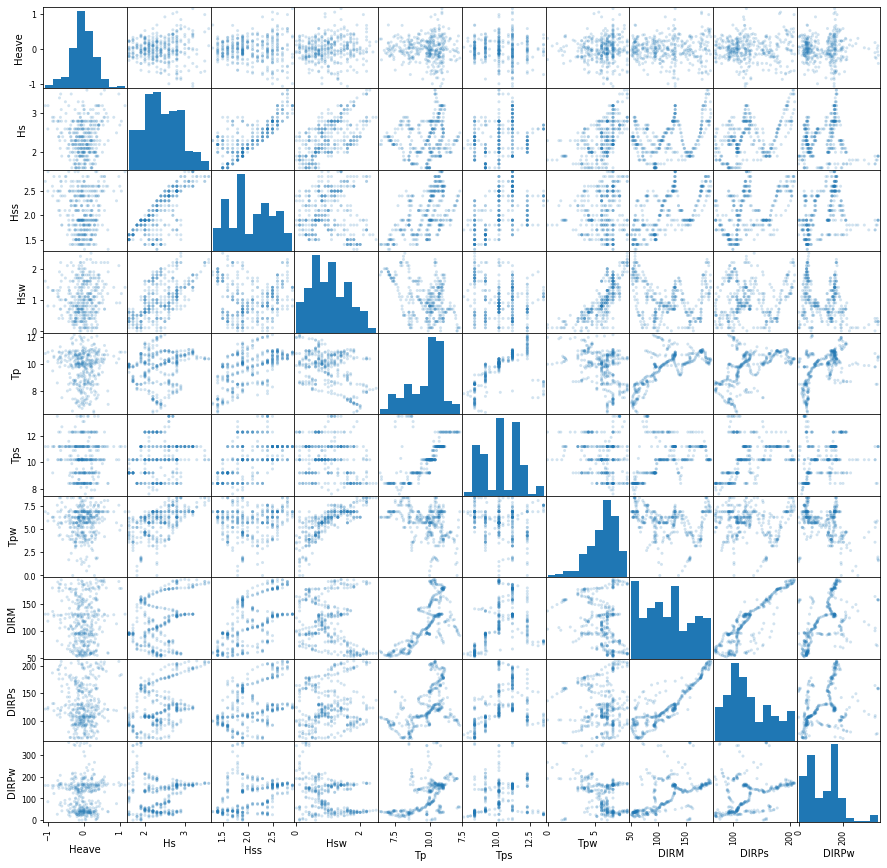

In [72]:
pd.plotting.scatter_matrix(complete_data_train_original_weather_data[model_output + model_inputs],
                           alpha=0.2,
                           figsize=(15, 15),);

__Conclusions:__
    
Even considering the actual data, without interpolation, the correlation between Heave and weather data is very small, probably still due to the oscillatory behavior of the movement that has no representation in the inputs. 
One idea here would be to apply some transformation to the inputs to gain this variability and another idea would be to use past data from the movement itself to bring the oscillatory behavior to the model.

# Case 2

With balancing, the idea is to make the model have the same capacity to predict values in the central region and in the amplitude peaks.

__1__ - Split the dataset into ranges based on Heave values.\
__2__ - Use over/undersample techniques to reduce points of central region and increase points in extreme points.\
__3__ - Mount a balanced dataset.\
__4__ - Train the model with this data.\
__5__ - Check the results during the test period.

In [30]:
print(f'Min Value of Heave {round(complete_data_train.Heave.min(), 2)}')
print(f'Min Value of Heave {round(complete_data_train.Heave.max(), 2)}')

Min Value of Heave -2.18
Min Value of Heave 2.16


In [31]:
inf_limit = np.round(np.arange(-2.2, 2.2, 0.2), 2)
sup_limit = np.round(np.arange(-2.0, 2.3, 0.2), 2)

In [32]:
# Named tuple used to store balancing informantion:
# dataframe
# min and max value to cut
# column used to cut
balancing_info = namedtuple('BalancingDataInfo', 'df length min max column')

In [33]:
def cut_dataset_based_on_min_max_value(df, min_value, max_value, column_name):
    """
    This function cut dataframes based on a column and min/max value.
    
    args:
    df (DataFrame) -> Dataframe used as reference to be cut.
    min_value (int/float) -> Value used as a minimum of the range.
    max_value (int/float) -> Value used as a maximum of the range.
    column_name (str) -> Name of column used as reference to cut the dataframe.
    
    Return:
    Filtered dataframe.
    """
    df_cut = df[(df[column_name] >= min_value) & (df[column_name] < max_value)].copy()
    return df_cut

In [73]:
datasets_limited_by_heave_range = []
column = 'Heave'

for index in range(len(inf_limit)):
    
    min_heave = inf_limit[index]
    max_heave = sup_limit[index]
    
    df_cut = cut_dataset_based_on_min_max_value(complete_data_train, min_heave, max_heave, column)
    datasets_limited_by_heave_range.append(balancing_info(df=df_cut, # dataset into heave limits
                                                          length=len(df_cut), # number of entries
                                                          min=min_heave, # min value used to cut
                                                          max=max_heave, # max value used to cut
                                                          column=column # reference column
                                                         )
                                          )
    
lengths = [x.length for x in datasets_limited_by_heave_range]
lengths

[2,
 12,
 53,
 241,
 895,
 3091,
 9504,
 27855,
 79274,
 202849,
 367565,
 367155,
 203145,
 78968,
 27762,
 9607,
 3213,
 886,
 255,
 54,
 13,
 1]

# Considering `895` as parameter to sample each df.

In [35]:
dfs = [x.df.sample(895, replace=True) for x in datasets_limited_by_heave_range]
balanced_train_data = pd.concat(dfs)

In [36]:
model_inputs = ['Hs', 'Hss', 'Hsw', 'Tp', 'Tps', 'Tpw', 'DIRM', 'DIRPs', 'DIRPw']
model_output = ['Heave']

In [37]:
corr_with_balanced_data = balanced_train_data[model_output + model_inputs].corr(method='spearman')

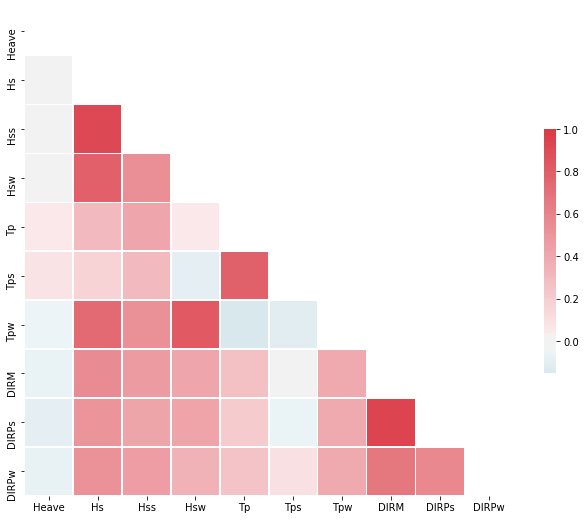

In [38]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_with_balanced_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr_with_balanced_data, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
display(np.abs(corr_with_balanced_data.Heave).sort_values(ascending=False))
model_input_corr_order = np.abs(corr_with_balanced_data.Heave).sort_values(ascending=False).index.tolist()
model_input_corr_order = [value for value in model_input_corr_order if value != 'Heave']

Heave    1.000000
DIRPs    0.087489
Tps      0.077972
DIRPw    0.067023
DIRM     0.062877
Tp       0.051330
Tpw      0.045482
Hsw      0.023309
Hs       0.016165
Hss      0.003364
Name: Heave, dtype: float64

In [40]:
# Define x and y to train the model.
x = balanced_train_data[model_inputs].copy()
y = balanced_train_data.Heave.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr = GradientBoostingRegressor()
gbr.fit(x_sc, y)

pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

acc(10%) >> 0.25
r2_score >> -0.22


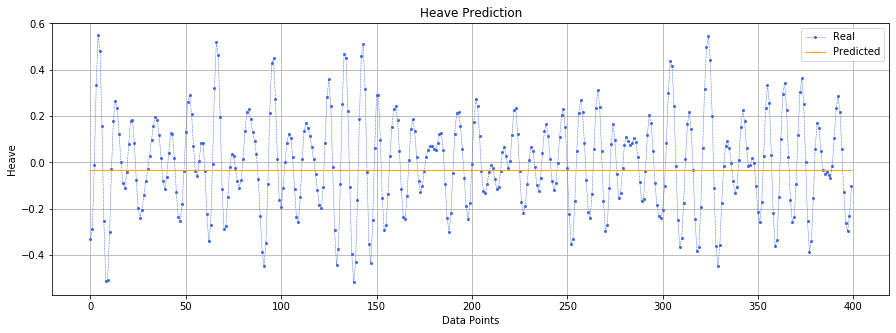

In [41]:
y_test_balanced_weather = complete_data_test.Heave.values
y_pred_balanced_weather = pipeline.predict(complete_data_test[model_inputs])

acc = calculate_accuracy(y_test_balanced_weather, y_pred_balanced_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_balanced_weather, y_pred_balanced_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_balanced_weather, y_pred_balanced_weather, start_num=0, end_num=400, title='Heave Prediction')

__Conclusions:__

A simple balancing technique also did not make the model capable of predicting variability. The model continues to respond at the same level.
As next steps, two tests will be done.

__1__ - Use past movement data to bring oscillatory behavior to the response.

__2__ - Apply trigonometric and / or nonlinear transformations to the features to try to include an oscillatory behavior.

# Use past behavior to get oscillatory behavior

- To begin this implementation, the interpolated dataset will be used as the basis for get points every 10 minutes. With this, it is possible to perform faster tests and conclude whether this is a good modeling alternative.

## 1° step: Use interpolated data to obtain original data (It has been done before)

- Base: `complete_data_train`

In [78]:
complete_data_train_by_minute = complete_data_train.resample('T').first()
complete_data_test_by_minute = complete_data_test.resample('T').first()

In [79]:
complete_data_train_by_minute.head()

Heave      Roll     Pitch        Hs       Hss  \
Date                                                                          
2020-08-15 00:00:00+00:00 -0.460648 -1.364725 -0.044143  2.600000  1.600000   
2020-08-15 00:01:00+00:00  0.426032 -0.510667  0.243371  2.601667  1.601667   
2020-08-15 00:02:00+00:00 -0.176302 -0.546234 -0.547085  2.603333  1.603333   
2020-08-15 00:03:00+00:00  0.579342 -0.358289 -0.220409  2.605000  1.605000   
2020-08-15 00:04:00+00:00  0.285081 -0.177924  0.434750  2.606667  1.606667   

                           Hsw        Tp        Tps       Tpw       DIRM  \
Date                                                                       
2020-08-15 00:00:00+00:00  2.1  8.000000  11.200000  8.400000  66.000000   
2020-08-15 00:01:00+00:00  2.1  7.998333  11.184999  8.395000  65.966667   
2020-08-15 00:02:00+00:00  2.1  7.996667  11.170000  8.389999  65.933334   
2020-08-15 00:03:00+00:00  2.1  7.995000  11.155000  8.384999  65.900002   
2020-08-15 00:04:00+00:00  2.1  7.993333  11.139999  8.380000  65.866669   

                                DIRPs      DIRPw  
Date                                              
2020-08-15 00:00:00+00:00  143.000000  46.000000  
2020-08-15 00:01:00+00:00  142.816666  45.950001  
2020-08-15 00:02:00+00:00  142.633331  45.900002  
2020-08-15 00:03:00+00:00  142.449997  45.849998  
2020-08-15 00:04:00+00:00  142.266663  45.799999

# Creating features based on a heave behavior.

- Include columns considering 10 minutes in the past for each 2 minutes.

In [80]:
intervals = [2, 4, 6, 8, 10]
column_names = []

for interval in intervals:
    
    column_name = f'lag_{interval}'
    column_names.append(column_name)
    
    complete_data_test_by_minute[column_name] = complete_data_test_by_minute.Heave.shift(interval, freq='T')
    complete_data_train_by_minute[column_name] = complete_data_train_by_minute.Heave.shift(interval, freq='T')

In [81]:
complete_data_train_by_minute.dropna(inplace=True)
complete_data_test_by_minute.dropna(inplace=True)

In [82]:
complete_data_test_by_minute.head()

Heave      Roll     Pitch   Hs  Hss       Hsw  \
Date                                                                          
2020-08-31 00:10:00+00:00 -0.193066 -0.132525 -0.142986  1.7  1.7  0.483333   
2020-08-31 00:11:00+00:00 -0.144494 -0.661623 -0.118864  1.7  1.7  0.481667   
2020-08-31 00:12:00+00:00 -0.051138 -0.331002 -0.525752  1.7  1.7  0.480000   
2020-08-31 00:13:00+00:00  0.045827 -0.730924 -0.365546  1.7  1.7  0.478333   
2020-08-31 00:14:00+00:00  0.365065 -0.527811 -0.317214  1.7  1.7  0.476667   

                            Tp  Tps       Tpw       DIRM  DIRPs      DIRPw  \
Date                                                                         
2020-08-31 00:10:00+00:00  8.3  8.4  5.166667  67.166664   71.0  15.166667   
2020-08-31 00:11:00+00:00  8.3  8.4  5.163333  67.183334   71.0  15.183333   
2020-08-31 00:12:00+00:00  8.3  8.4  5.160000  67.199997   71.0  15.200000   
2020-08-31 00:13:00+00:00  8.3  8.4  5.156667  67.216667   71.0  15.216666   
2020-08-31 00:14:00+00:00  8.3  8.4  5.153333  67.233330   71.0  15.233334   

                              lag_2     lag_4     lag_6     lag_8    lag_10  
Date                                                                         
2020-08-31 00:10:00+00:00 -0.003616 -0.334352  0.115789 -0.183902 -0.329711  
2020-08-31 00:11:00+00:00  0.081290 -0.070048 -0.205345  0.056103 -0.036630  
2020-08-31 00:12:00+00:00 -0.193066 -0.003616 -0.334352  0.115789 -0.183902  
2020-08-31 00:13:00+00:00 -0.144494  0.081290 -0.070048 -0.205345  0.056103  
2020-08-31 00:14:00+00:00 -0.051138 -0.193066 -0.003616 -0.334352  0.115789

# Correlation Analysis

In [46]:
model_inputs = column_names + ['Hs', 'Hss', 'Hsw', 'Tp', 'Tps', 'Tpw', 'DIRM', 'DIRPs', 'DIRPw']
model_output = ['Heave']

In [47]:
corr_with_shifted_data = complete_data_train_by_minute[model_output + model_inputs].corr(method='spearman')

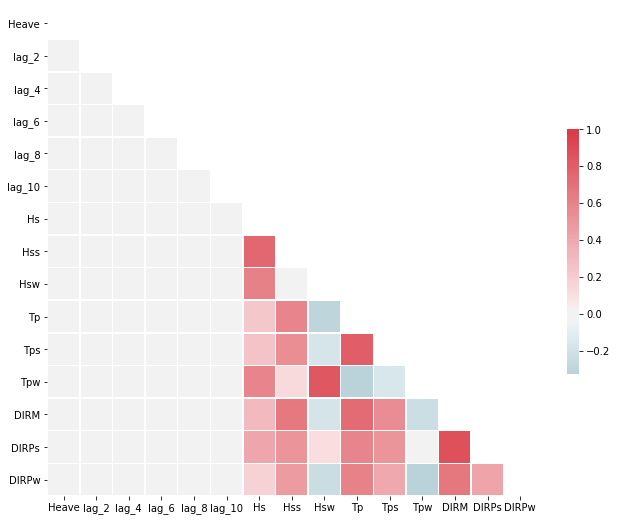

In [48]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_with_shifted_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr_with_shifted_data, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
display(np.abs(corr_with_shifted_data.Heave).sort_values(ascending=False))
model_input_corr_order = np.abs(corr_with_shifted_data.Heave).sort_values(ascending=False).index.tolist()
model_input_corr_order = [value for value in model_input_corr_order if value != 'Heave']

Heave     1.000000
Hsw       0.011514
Tpw       0.010589
Tp        0.010397
Hs        0.006820
lag_4     0.003455
lag_10    0.003250
DIRM      0.003191
Tps       0.002614
lag_2     0.002358
DIRPw     0.002066
lag_8     0.001967
DIRPs     0.001824
Hss       0.000696
lag_6     0.000565
Name: Heave, dtype: float64

In [50]:
# Define x and y to train the model.
x = complete_data_train_by_minute[model_inputs].copy()
y = complete_data_train_by_minute.Heave.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr = GradientBoostingRegressor(loss='huber',
                                learning_rate=0.1,
                                n_estimators=5000,
                                subsample=1.0,
                                min_samples_split=2,
                                max_depth=3)

gbr.fit(x_sc, y)

pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

acc(10%) >> 1.53
r2_score >> -1.38


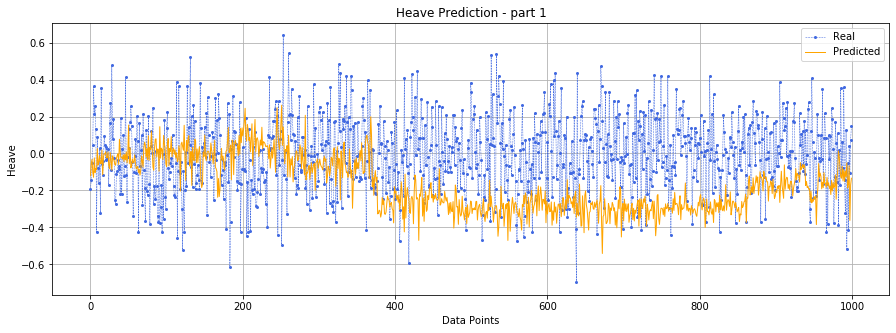

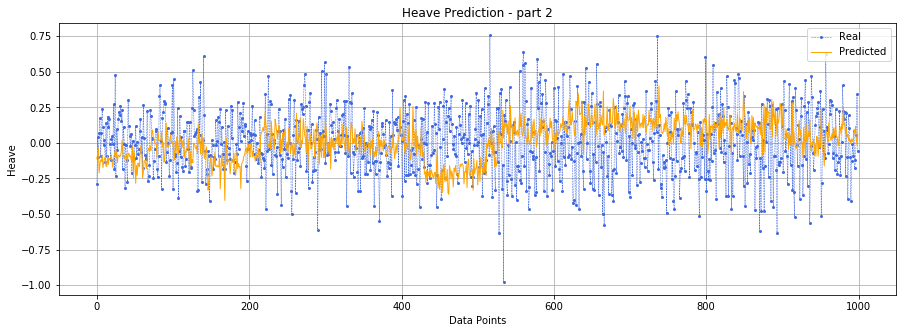

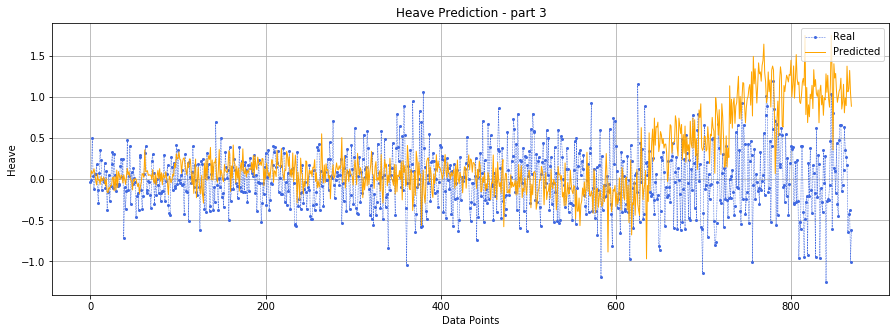

In [51]:
y_test_shifted_weather = complete_data_test_by_minute.Heave.values
y_pred_shifted_weather = pipeline.predict(complete_data_test_by_minute[model_inputs])

acc = calculate_accuracy(y_test_shifted_weather, y_pred_shifted_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_shifted_weather, y_pred_shifted_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_shifted_weather, y_pred_shifted_weather, start_num=0,
                    end_num=1000, title='Heave Prediction - part 1')
plot_model_accuracy(y_test_shifted_weather, y_pred_shifted_weather, start_num=1000,
                    end_num=2000, title='Heave Prediction - part 2')
plot_model_accuracy(y_test_shifted_weather, y_pred_shifted_weather, start_num=2000,
                    end_num=3500, title='Heave Prediction - part 3')

In [52]:
print(f'Min. Value [Heave]: {y_test_shifted_weather.min()}')
print(f'Max. Value [Heave]: {y_test_shifted_weather.max()}')

Min. Value [Heave]: -1.2571492195129395
Max. Value [Heave]: 1.1975511312484741


In [53]:
print(f'Min. Value [Heave]: {y_pred_shifted_weather.min()}')
print(f'Max. Value [Heave]: {y_pred_shifted_weather.max()}')

Min. Value [Heave]: -0.9698260949542296
Max. Value [Heave]: 1.7542836575105407


## Plotting feature importance

In [54]:
def plot_feature_importance(inputs, model_feature_importance, plot_title="Feature Importances"):
    """
    Function to plot the feature importance considering a prediction model.
    
    args:
    inputs (list) -> List of features used to train the model.
    model_feature_importance (list) -> List of importances considering in the order used on the model.
    plot_title (str) -> Title to use when plot the feature importance.
    
    Return:
    None    
    """
    _dict = {'Features': inputs,
             'Importances': model_feature_importance}
    
    df_fi = pd.DataFrame(_dict)
    fi_mean = df_fi.groupby(["Features"])['Importances'].aggregate(np.mean).reset_index().sort_values('Importances', ascending=False)
    fig = plt.figure(figsize=(20,8))
    sns.barplot(y='Features', x="Importances", data=df_fi, palette='rocket', order=fi_mean['Features'])
    plt.title(plot_title)
    plt.show()
    
    return None

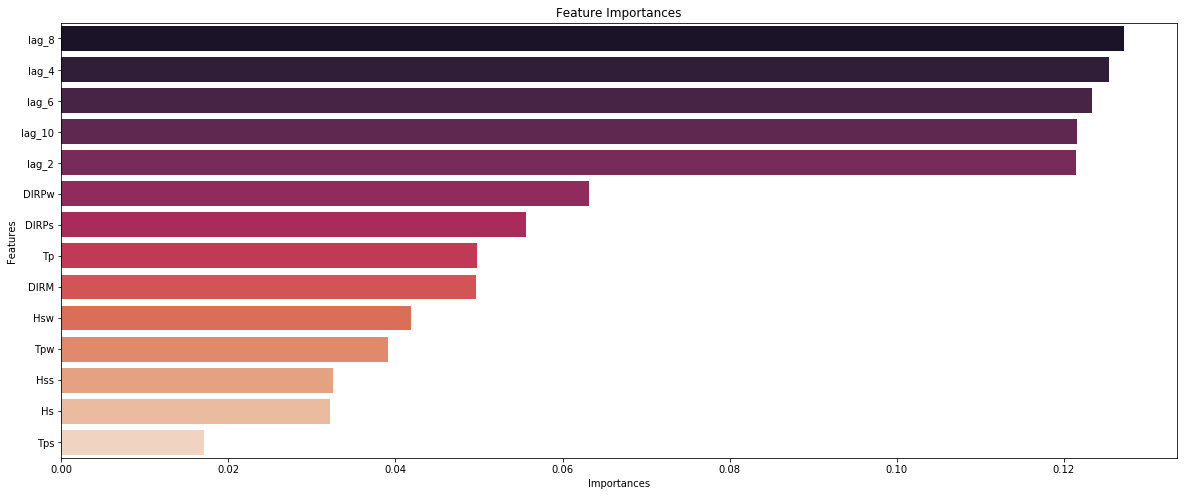

In [55]:
plot_feature_importance(model_inputs, gbr.feature_importances_)

__Conclusions:__

- Finally, an oscillatory response was obtained. Mainly because of the relationship between the current point and its history, considered through the application of shifts of different time ranges. This is a path to be explored where it is possible to combine the two effects, the history contributing to the oscillatory behavior and the weather data to improve the model's behavior in general.
- Analyzing the minimum and maximum values of the test data and the predicted values, it is noted that the model can reach values close to the highest amplitudes.
- The feature importance analysis showed that the movement history is the most important input for the model at this time.

## 2° step: application of trigonometric transformations in weather data

- Base: `complete_train_data`

In [88]:
complete_data_train_by_minute = complete_data_train.resample('T').first()
complete_data_test_by_minute = complete_data_test.resample('T').first()

The idea is to use Height and Period to build an oscillatory function to improve the model, mainly by identifying which phenomena affect the vessel's response most.

__1__ - Create a time column based on second - Basically `minute` *  `60`.\
__2__ - Development of a trigonometric function based on the amplitude and period of each phenomenon.\
__3__ - Apply the prediction model correlating vessel response and oscillatory weather data.

In [89]:
def calculate_weather_oscilatory_behavior(df):
    """
    This function calculates senoidal function for each of weather data, grouping by total_sea, swell and wind.
    
    args:
    df (DataFrame) -> Data frame with weather data with datetime on index.
    
    return:
    Data frame with oscillatory data included.
    """
    
    weather_columns = namedtuple('WeatherData', 'Hs Tp DIR')

    total_sea_columns = weather_columns(df.Hs, df.Tp, df.DIRM)
    swell_columns = weather_columns(df.Hss, df.Tps, df.DIRPs)
    wind_columns = weather_columns(df.Hsw, df.Tpw, df.DIRPw)
    
    time_s = df.index.minute * 60
    df['osc_behavior_total_sea'] = total_sea_columns.Hs * np.sin((2 * np.pi * time_s) / total_sea_columns.Tp)
    df['osc_behavior_swell'] = swell_columns.Hs * np.sin((2 * np.pi * time_s) / swell_columns.Tp)
    df['osc_behavior_wind'] = wind_columns.Hs * np.sin((2 * np.pi * time_s) / wind_columns.Tp)
    
    return df

In [90]:
# Apply transformations on train and test data
complete_data_train_by_minute = calculate_weather_oscilatory_behavior(complete_data_train_by_minute)
complete_data_test_by_minute = calculate_weather_oscilatory_behavior(complete_data_test_by_minute)

In [91]:
model_inputs = ['osc_behavior_total_sea', 'osc_behavior_swell', 'osc_behavior_wind']
model_output = ['Heave']

# Correlation Analysis

In [60]:
corr_with_osc_data = complete_data_train_by_minute[model_output + model_inputs].corr(method='spearman')

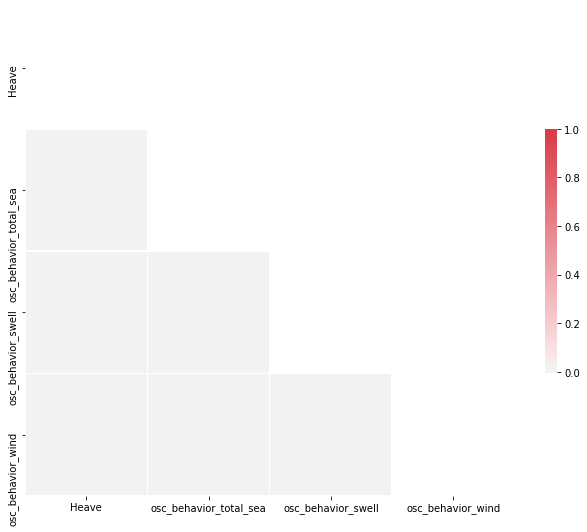

In [61]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_with_osc_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr_with_osc_data, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [62]:
display(np.abs(corr_with_osc_data.Heave).sort_values(ascending=False))
model_input_corr_order = np.abs(corr_with_osc_data.Heave).sort_values(ascending=False).index.tolist()
model_input_corr_order = [value for value in model_input_corr_order if value != 'Heave']

Heave                     1.000000
osc_behavior_wind         0.005471
osc_behavior_total_sea    0.001849
osc_behavior_swell        0.001604
Name: Heave, dtype: float64

In [63]:
# Define x and y to train the model.

# In this case, the function dropna() was used because there are two points with period zero for wind.
data_to_use = complete_data_train_by_minute.dropna().copy()
x = data_to_use[model_inputs]
y = data_to_use.Heave.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr_heave = GradientBoostingRegressor(loss='huber',
                                      learning_rate=0.1,
                                      n_estimators=5000,
                                      subsample=1.0,
                                      min_samples_split=2,
                                      max_depth=3)

gbr_heave.fit(x_sc, y)

pipeline_heave = Pipeline([('scaler', scaler), ('model', gbr_heave)])

acc(10%) >> 1.04
r2_score >> -0.28


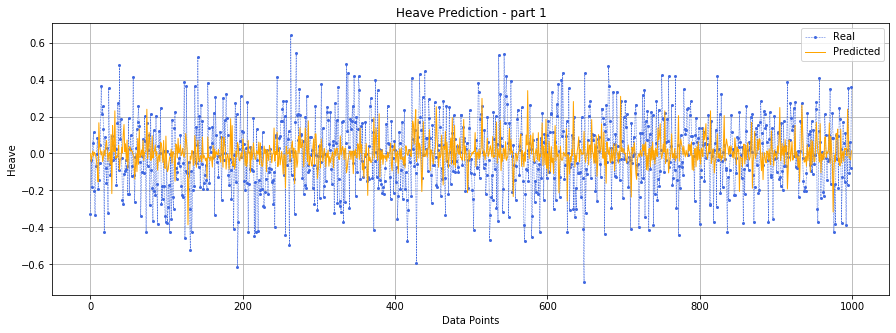

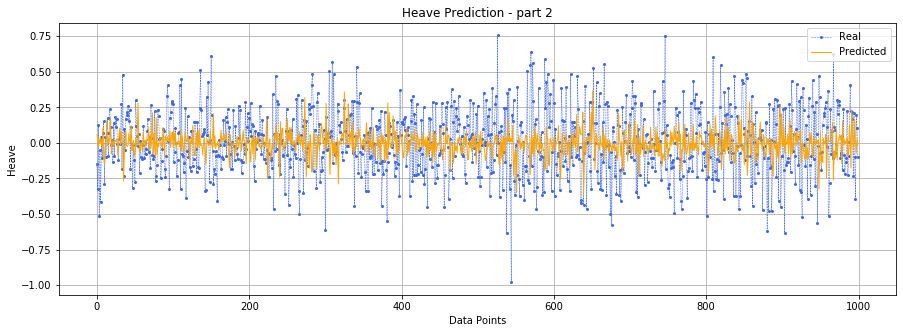

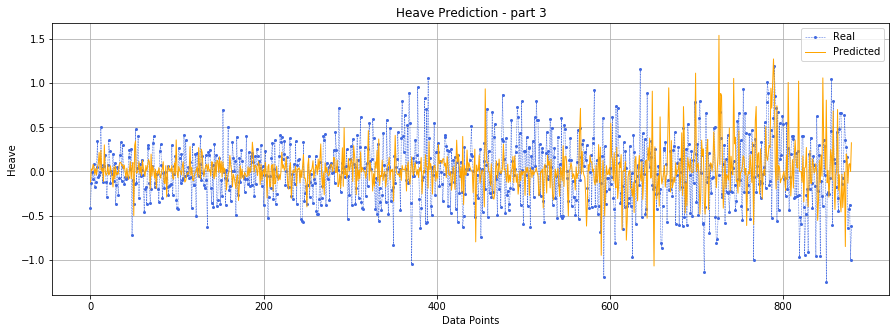

In [64]:
y_test_osc_weather = complete_data_test_by_minute.Heave.values
y_pred_osc_weather = pipeline_heave.predict(complete_data_test_by_minute[model_inputs])

acc = calculate_accuracy(y_test_osc_weather, y_pred_osc_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_osc_weather, y_pred_osc_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=0,
                    end_num=1000, title='Heave Prediction - part 1')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=1000,
                    end_num=2000, title='Heave Prediction - part 2')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=2000,
                    end_num=3500, title='Heave Prediction - part 3')

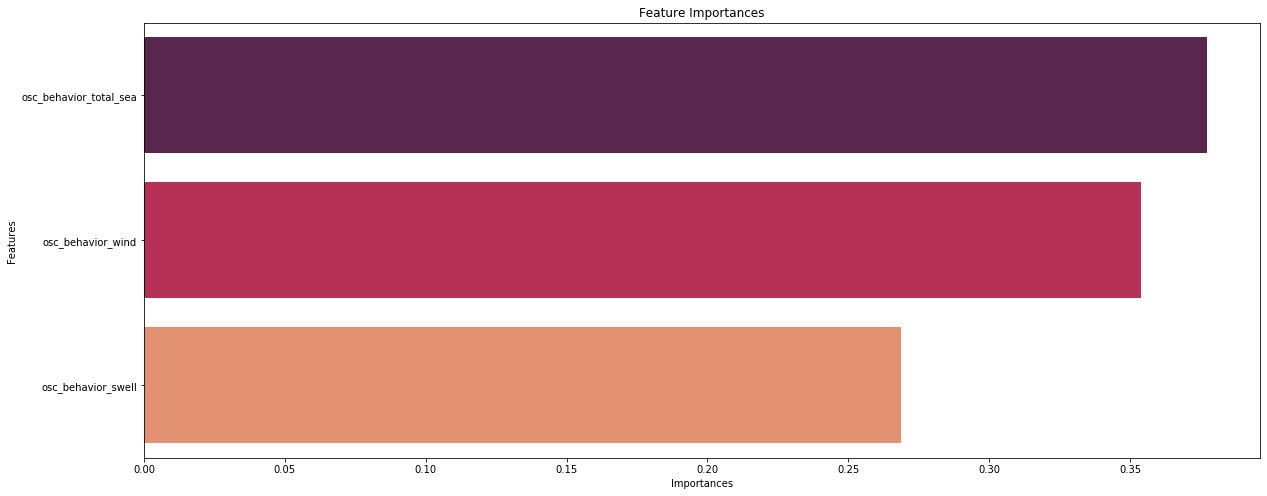

In [86]:
plot_feature_importance(model_inputs, gbr_heave.feature_importances_)

# Apply the model on pitch movement.

In [92]:
# Define x and y to train the model.

# In this case, the function dropna() was used because there are two points with period zero for wind.
data_to_use = complete_data_train_by_minute.dropna().copy()
x = data_to_use[model_inputs]
y = data_to_use.Pitch.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr = GradientBoostingRegressor(loss='huber',
                                learning_rate=0.1,
                                n_estimators=5000,
                                subsample=1.0,
                                min_samples_split=2,
                                max_depth=3)

gbr.fit(x_sc, y)

pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

acc(10%) >> 0.66
r2_score >> -0.33


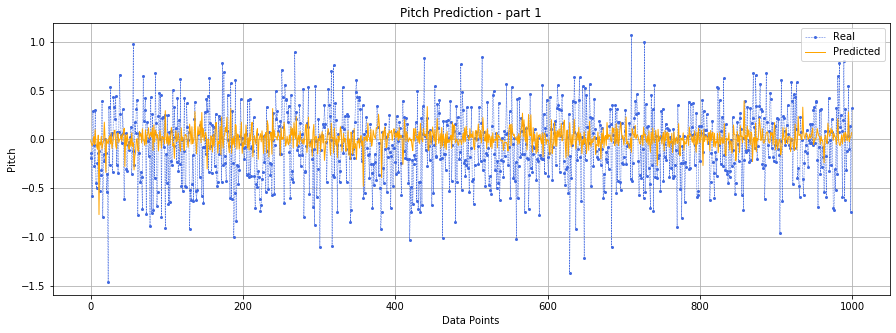

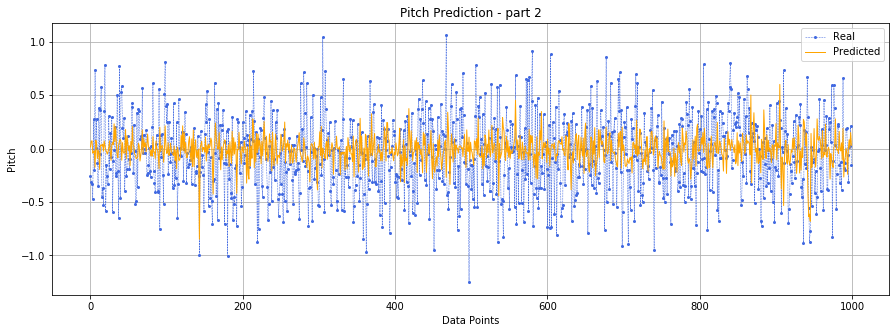

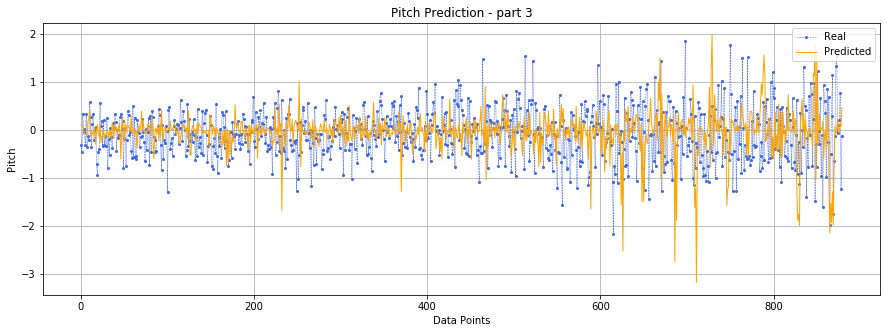

In [93]:
y_test_osc_weather = complete_data_test_by_minute.Pitch.values
y_pred_osc_weather = pipeline.predict(complete_data_test_by_minute[model_inputs])

acc = calculate_accuracy(y_test_osc_weather, y_pred_osc_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_osc_weather, y_pred_osc_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=0,
                    end_num=1000, title='Pitch Prediction - part 1')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=1000,
                    end_num=2000, title='Pitch Prediction - part 2')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=2000,
                    end_num=3500, title='Pitch Prediction - part 3')

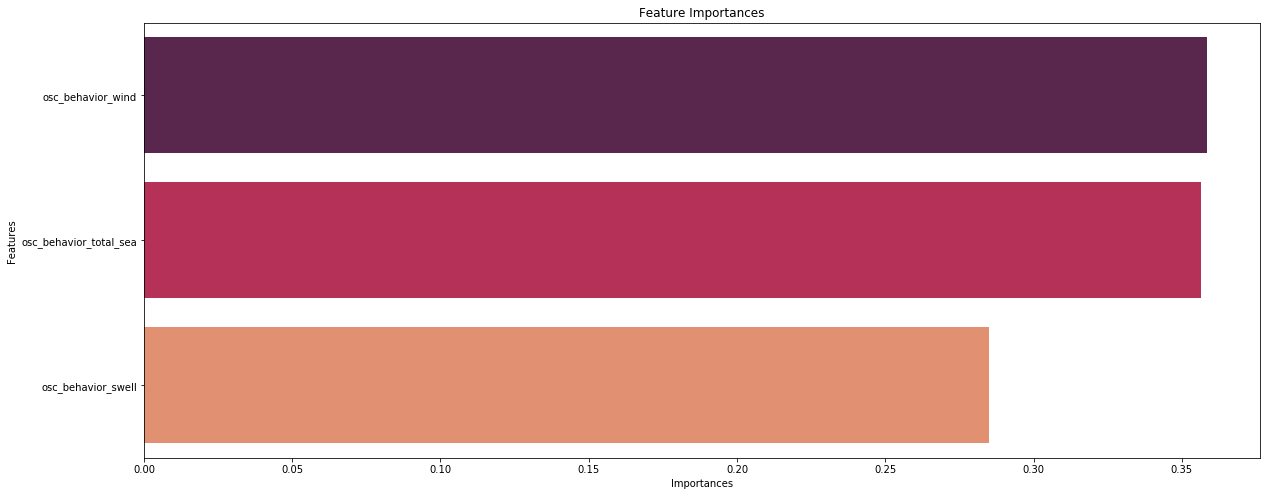

In [94]:
plot_feature_importance(model_inputs, gbr.feature_importances_)

# Apply the model on roll movement.

In [95]:
# Define x and y to train the model.

# In this case, the function dropna() was used because there are two points with period zero for wind.
data_to_use = complete_data_train_by_minute.dropna().copy()
x = data_to_use[model_inputs]
y = data_to_use.Roll.values

# Defining MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(x)

# Define GBR
gbr = GradientBoostingRegressor(loss='huber',
                                learning_rate=0.1,
                                n_estimators=5000,
                                subsample=1.0,
                                min_samples_split=2,
                                max_depth=3)

gbr.fit(x_sc, y)

pipeline = Pipeline([('scaler', scaler), ('model', gbr)])

acc(10%) >> 0.52
r2_score >> -0.48


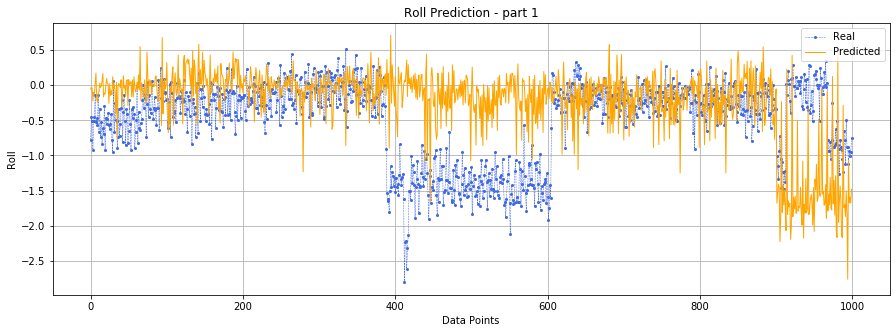

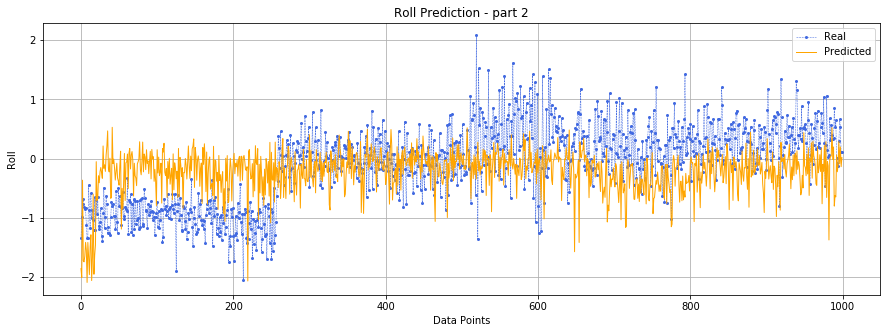

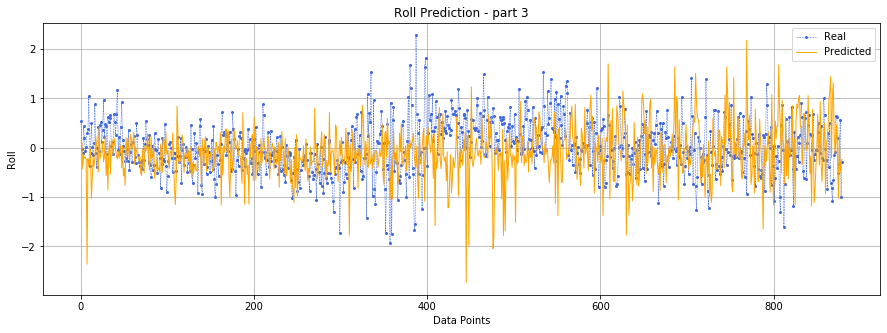

In [96]:
y_test_osc_weather = complete_data_test_by_minute.Roll.values
y_pred_osc_weather = pipeline.predict(complete_data_test_by_minute[model_inputs])

acc = calculate_accuracy(y_test_osc_weather, y_pred_osc_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_test_osc_weather, y_pred_osc_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=0,
                    end_num=1000, title='Roll Prediction - part 1')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=1000,
                    end_num=2000, title='Roll Prediction - part 2')
plot_model_accuracy(y_test_osc_weather, y_pred_osc_weather, start_num=2000,
                    end_num=3500, title='Roll Prediction - part 3')

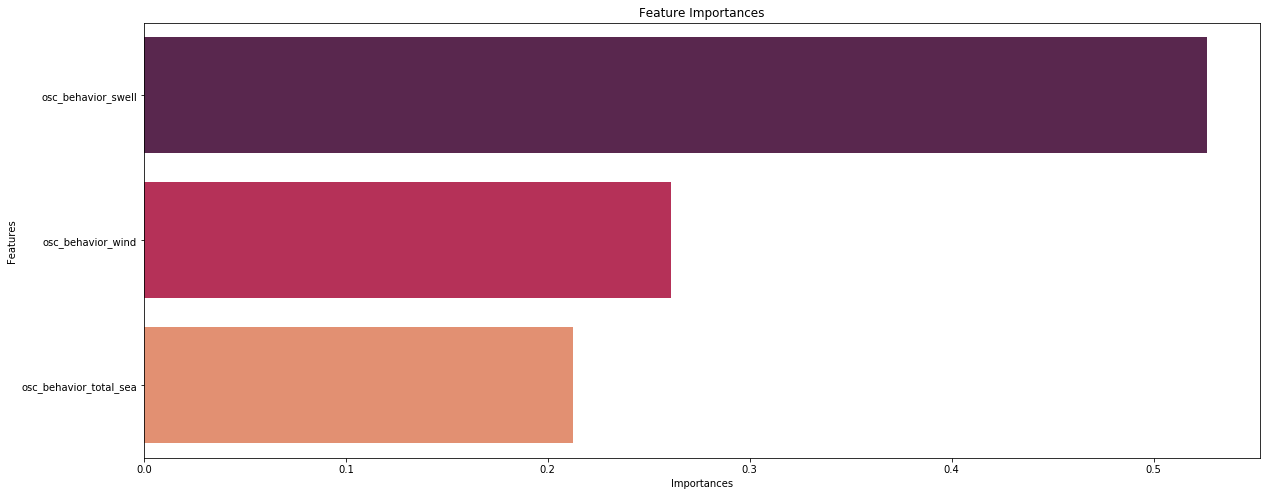

In [97]:
plot_feature_importance(model_inputs, gbr.feature_importances_)

# Applying model on validation period for Heave

In [98]:
validation_filename = 'complete_data_validation.csv'
complete_data_validation = read_files_into_dataframes(base_path, validation_filename, date_column_name='Date')

complete_data_validation_by_minute = complete_data_validation.resample('T').first()

In [99]:
complete_data_validation_by_minute = calculate_weather_oscilatory_behavior(complete_data_validation_by_minute)

acc(10%) >> 1.25
r2_score >> -0.27


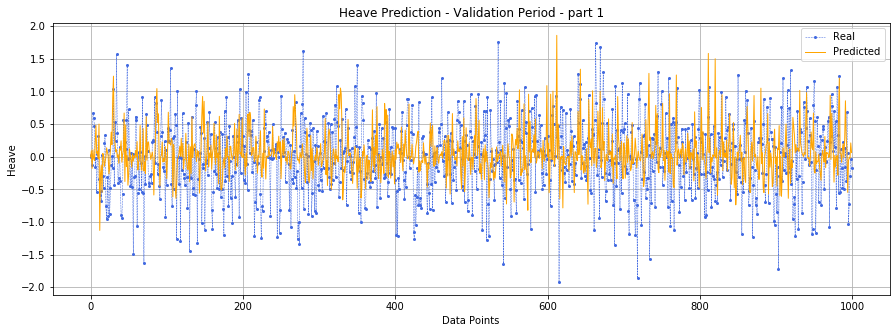

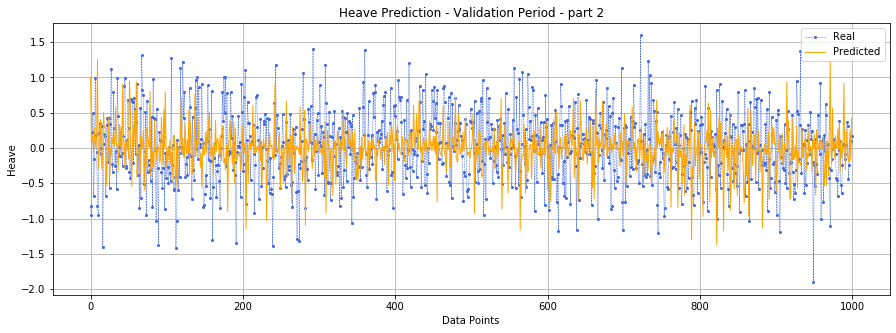

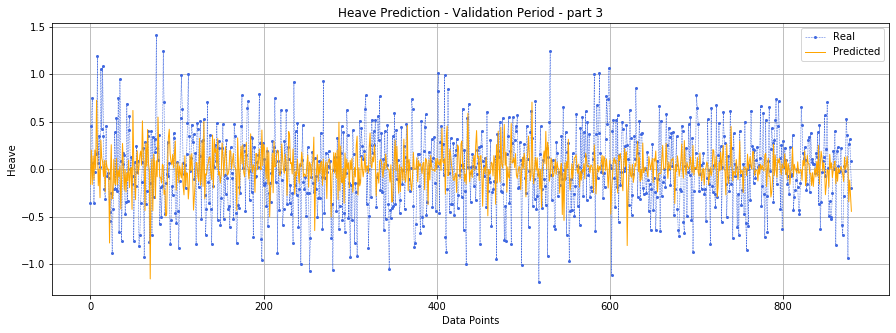

In [100]:
y_valid_osc_weather = complete_data_validation_by_minute.Heave.values
y_valid_pred_osc_weather = pipeline_heave.predict(complete_data_validation_by_minute[model_inputs])

acc = calculate_accuracy(y_valid_osc_weather, y_valid_pred_osc_weather)
print(f'acc(10%) >> {acc}')

r2_score_original_weather = r2_score(y_valid_osc_weather, y_valid_pred_osc_weather)
r2_score_original_weather = round(r2_score_original_weather, 2)
print(f'r2_score >> {r2_score_original_weather}')

plot_model_accuracy(y_valid_osc_weather, y_valid_pred_osc_weather, start_num=0,
                    end_num=1000, title='Heave Prediction - Validation Period - part 1')
plot_model_accuracy(y_valid_osc_weather, y_valid_pred_osc_weather, start_num=1000,
                    end_num=2000, title='Heave Prediction - Validation Period - part 2')
plot_model_accuracy(y_valid_osc_weather, y_valid_pred_osc_weather, start_num=2000,
                    end_num=3500, title='Heave Prediction - Validation Period - part 3')

__Conclusions:__

- The trigonometric transformation methodology of the features proved to be effective in capturing the oscillatory behavior of the response.


- About feature importance:

1) Heave: 
- Total sea 
- Wind
- Swell

2) Pitch: 
- Swell
- Wind
- Total sea

3) Roll:
- Wind
- Total sea
- Swell


- In general, the correlation analysis does not have a considerable result when comparing features and oscillatory responses.


- The presence of features with oscillatory behavior was important to obtain the oscillatory response of the movements.


- In this sense, we concluded two paths to be explored, one with the consideration of the history of movements and the other with the trigonometric transformation.